# Morpion Solitaire: exploration with a model

In [1]:
import sys, os
sys.path.append(os.getcwd() + '/../cpp/bin')

import PyMorpionSolitaire

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

## Model

In [4]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

In [5]:
net = torch.load('models/model-128-res-4.pt', map_location=device)
net.eval()

Sequential(
  (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(3, 3))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
  (9): ReLU()
  (10): ResNet(
    (module): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (11): ResNet(
    (module): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

## Game

In [6]:
game = PyMorpionSolitaire.Game5T('c')

In [7]:
state = game.image()[48:144, 48:144]
actions = game.getMoveImages()[:, 48:144, 48:144]

state = np.expand_dims(state, 0).repeat(actions.shape[0], axis=0)
actions = actions ^ state

x = torch.tensor(np.concatenate([np.expand_dims(state, 1), np.expand_dims(actions, 1)], axis = 1)).float()
x.shape

torch.Size([28, 2, 96, 96])

In [8]:
with torch.no_grad():
    y = net(x).data

In [9]:
y.min().item(), y.mean().item(), y.max().item()

(-0.0034290533512830734, -0.0009462749003432691, -0.0007722005248069763)

  0  -0.003  -0.001  -0.001
  1  -0.002  -0.001  -0.000
  2  -0.006  -0.001  -0.000
  3  -0.009  -0.002  -0.001
  4  -0.006  -0.002  -0.001
  5  -0.011  -0.002  -0.001
  6  -0.013  -0.003  -0.000
  7  -0.013  -0.003  -0.000
  8  -0.013  -0.003  -0.001
  9  -0.016  -0.006  -0.001
 10  -0.010  -0.002  -0.001
 11  -0.011  -0.003  -0.001
 12  -0.013  -0.004  -0.001
 13  -0.011  -0.004  -0.001
 14  -0.009  -0.003  -0.001
 15  -0.007  -0.001  -0.001
 16  -0.007  -0.001  -0.001
 17  -0.012  -0.004  -0.000
 18  -0.012  -0.003   0.013
 19  -0.009  -0.003  -0.001
 20  -0.010  -0.002   0.013
 21  -0.007  -0.002  -0.001
 22  -0.006  -0.002  -0.001
 23  -0.006  -0.001   0.013
 24  -0.006  -0.000   0.013
 25  -0.005   0.004   0.032
 26  -0.008   0.003   0.039
 27  -0.006   0.001   0.013
 28  -0.050   0.002   0.065
 29  -0.039   0.006   0.046
 30  -0.009   0.001   0.015
 31  -0.012   0.001   0.014
 32  -0.013   0.003   0.029
 33  -0.009   0.003   0.013
 34  -0.007  -0.001   0.013
 35  -0.008  -0.001 

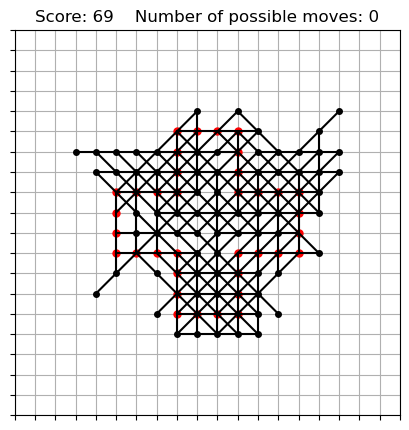

In [10]:
game = PyMorpionSolitaire.Game5T('c')

with torch.no_grad():
    while game.getNumberOfMoves() > 0:
        state = game.image()[48:144, 48:144]
        actions = game.getMoveImages()[:, 48:144, 48:144]
        
        state = np.expand_dims(state, 0).repeat(actions.shape[0], axis=0)
        actions = actions ^ state
        
        x = torch.tensor(np.concatenate([np.expand_dims(state, 1), np.expand_dims(actions, 1)], axis = 1)).float()
        y = net(x).data.squeeze(1)
        i = np.argmax(y).item()
        s = game.getScore()
        game.playByIndex(i)
        print("%3d %7.3f %7.3f %7.3f" % (s, y.min().item(), y.mean().item(), y[i].item()))

game.print()

In [11]:
scores = {1e-4: [game.getScore()]}

In [12]:
def play_random():
    game = PyMorpionSolitaire.Game5T('c')
    game.playAtRandom()
    return game.getScore()

In [13]:
scores[100] = [play_random() for _ in trange(100000)]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [14]:
def play(t):
    game = PyMorpionSolitaire.Game5T('c')
    while True:
        n = game.getNumberOfMoves()
        if n == 0:
            return game.getScore()
        if n == 1:
            game.playByIndex(0)
        else:
            state = game.image()[48:144, 48:144]
            actions = game.getMoveImages()[:, 48:144, 48:144]
            
            state = np.expand_dims(state, 0).repeat(actions.shape[0], axis=0)
            actions = actions ^ state
            
            x = torch.tensor(np.concatenate([np.expand_dims(state, 1), np.expand_dims(actions, 1)], axis = 1)).float()
            y = net(x).data.squeeze()
            p = torch.exp((y - y.max()) / t)
            p /= p.sum()
            index = np.random.choice(range(len(p)), p=np.array(p))
            game.playByIndex(index)

In [15]:
t_list = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
for t in tqdm(t_list):
    if t not in scores:
        scores[t] = []
    for _ in tqdm(range(50), leave=False):
        s = play(t)
        # print(s)
        scores[t] = scores[t] + [s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
scores_mean = {t: np.mean(score, where = np.array(score) > 45).item() for t, score in scores.items()}
sorted(scores_mean.items())

[(0.0001, 69.0),
 (0.001, 72.32),
 (0.003, 71.58),
 (0.01, 69.86),
 (0.03, 68.42857142857143),
 (0.1, 64.97826086956522),
 (0.3, 65.54545454545455),
 (1, 63.54761904761905),
 (3, 63.87096774193548),
 (100, 63.78009643826735)]

In [17]:
scores_std = {t: np.std(score, where = np.array(score) > 45).item() for t, score in scores.items()}
sorted(scores_std.items())

[(0.0001, 0.0),
 (0.001, 5.077164563021372),
 (0.003, 5.628818703777907),
 (0.01, 4.833259769555118),
 (0.03, 4.508495382302715),
 (0.1, 4.265580802671657),
 (0.3, 4.6732047863545),
 (1, 4.2717364649874945),
 (3, 4.688640600043767),
 (100, 4.494662414754991)]

In [18]:
scores_max = {t: np.max(score).item() for t, score in scores.items()}
sorted(scores_max.items())

[(0.0001, 69),
 (0.001, 85),
 (0.003, 83),
 (0.01, 82),
 (0.03, 79),
 (0.1, 73),
 (0.3, 76),
 (1, 72),
 (3, 76),
 (100, 87)]

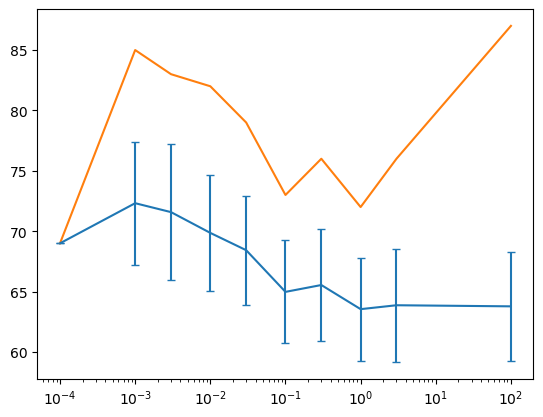

In [19]:
x = sorted(list(scores_mean.keys()))

plt.errorbar(x, [scores_mean[i] for i in x], [scores_std[i] for i in x], capsize = 3)
plt.plot(x, [scores_max[i] for i in x], label="max")
plt.xscale('log')
plt.show()

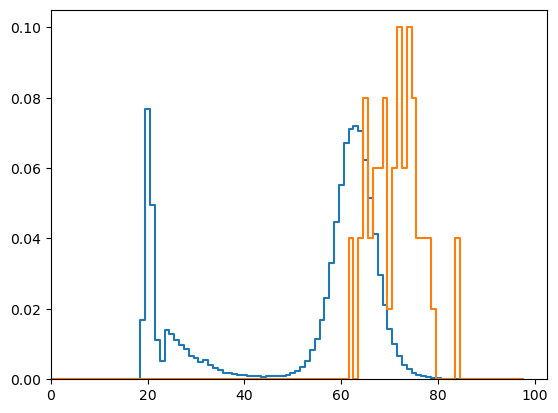

In [24]:
bins = [i - 0.5 for i in range(100)]

dist_0, bins = np.histogram(scores[100], bins, density=True)
dist, bins = np.histogram(scores[0.001], bins, density=True)

plt.step(bins[:-1], dist_0)
plt.step(bins[:-1], dist)
plt.xlim(0)
plt.ylim(0)
plt.show()